# Домашнее задание 1-3 (продолжение)

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне в Piazza через Private Post.
Файл с Вашим решением должен называться ```Surname_HW#```, где вместо ```Surname``` Вы пишите свою фамилию латиницей, а вместо ```#``` - номер домашнего задания. 
Решение задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача

__1.__ Скачайте с помощью кода, приведённого ниже, набор фотографий и нарисуйте какую-нибудь из них.

In [1]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np

Shape of data = (400, 64, 64)


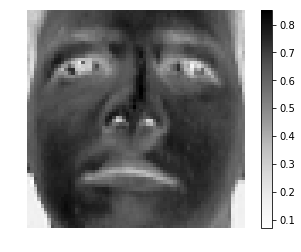

In [2]:
print("Shape of data = {}".format(data["images"].shape))
index = 6
plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [3]:
data["images"][index].shape

(64, 64)

__2.__ Одним из способов обработки изображений, например для выделения наиболее важных сегментов используется метод неотрицательной матричной факторизации ([Nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)). 
Идея в том, чтобы решить следующую задачу

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

где знак $\geq$ означает покомпонентное сравнение. 
Также матрицы $W$ и $H$ малого ранга, то есть $W \in \mathbb{R}^{m \times k}$ и $H \in \mathbb{R}^{k \times n}$, где $k$ - параметр, который необходимо настраивать.
Чем больше $k$, тем точнее приближение, но и тем дольше будет решаться задача.
Матрица $X \in \mathbb{R}^{m \times n}$, где $m$ - это число фото в нашем наборе, а $n$ - это количество пикселей в каждой картинке, то есть каждая строка матрицы $X$ - это векторизованная картинка.

**Вопросы**

1) является ли эта задача выпуклой и почему?

2) как можно интерпретировать факторы $W$ и $H$ и почему важна их покомпонентная неотрицательность?

$J(\mathbf{W},\mathbf{H}) = \Vert \mathbf{X} - \mathbf{W} \mathbf{H} \Vert_F^2 = \sum\limits_{i=1}^{n} \sum\limits_{j=1}^{n} (\sum\limits_{r=1}^{n}w_{ir}h_{rj}-x_{ij})^2$

$\dfrac{\partial J(\mathbf{W}, \mathbf{H})}{\partial w_{pq}} =\sum\limits_{j=1}^{n}2h_{qj}(\sum\limits_{r=1}^{n}w_{pr}h_{rj}-x_{pj})=\sum\limits_{j=1}^{n} \sum\limits_{r=1}^{n} 2h_{qj}w_{pr}h_{rj}-\sum\limits_{j=1}^{n} 2h_{qj} x_{pj}=\sum\limits_{j=1}^{n} \sum\limits_{r=1}^{n} 2 w_{pr}h_{rj}h_{jq}^\text{T}-\sum\limits_{j=1}^{n} 2 x_{pj}h_{jq}^\text{T}  = (2(\mathbf{W}\mathbf{H}-\mathbf{X})\mathbf{H}^\text{T})_{pq}$

$\dfrac{\partial J(\mathbf{W}, \mathbf{H})}{\partial h_{pq}} =\sum\limits_{i=1}^{n}2w_{ip} (\sum\limits_{r=1}^{n}w_{ir}h_{rq}-x_{iq}) = 2\sum\limits_{i=1}^{n} \sum\limits_{r=1}^{n} w_{pi}^\text{T} w_{ir}h_{rq}- 2\sum\limits_{i=1}^{n} w_{pi}^\text{T} x_{iq} = 2 (\mathbf{W}^\text{T} (\mathbf{W}\mathbf{H} - \mathbf{X}))_{pq} $

__3.__ Такую задачу можно решать с помощью CVXPy, если воспользоваться идеей попеременной оптимизации (alternating optimization). Идея состоит в том, чтобы на чётных итерациях решить точно задачу относительно параметра $W$ при фиксированном параметре $H$, а на нечётных наоборот: использовать решение для $W$ с предыдущей итерации в качестве фиксированного параметра и найти решение задачи относительной $H$ и так далее до сходимости.
Сначала Вам нужно инициализировать матрицы $W$ и $H$ какими-нибудь матрицами с неотрицательными элементами. От инициализации будет сильно зависеть качество решения и скорость работы методов.

**Задачи**

1) реализуйте с помощью CVXPy идею попеременной оптимизации для этой задачи и решите её

2) нарисуйте график сходимости по функции и убедитесь, что метод сошёлся или же изменение целевой функции пренебрежимо мало

3) поскольку размерность $H$ - $k \times n$, то каждую строку $H$ можно преобразовать в картинку аналогично тому, как были собраны строки матрицы $X$. Нарисуйте 10-50 картинок полученных из строк матрицы $H$. Что Вы заметили и как это соотносится с ответами на вопрос 2) предыдущего пункта? Используйте ```plt.colorbar()``` и цветовую схему ```plt.cm.Greys``` для более чёткого отображения значений пикселей

4) Нарисуйте матрицу $W$ с помощью функции ```plt.imshow``` или ```plt.spy```. Насколько сильно она заполнена и почему?

In [4]:
import cvxpy as cp
import numpy as np

# Ensure repeatably random problem data.
#np.random.seed(0)

# Generate random data matrix A.
#===============
#iters= 100
#index = 0
#A=np.array(data["images"][index].flatten())
#for i in range(iters-1):
#    A = np.vstack((A, np.array(data["images"][index+i+1].flatten())))
    
A=data["images"].reshape(400,4096)

A = np.delete(A, np.s_[17:399], axis=0)

m = A.shape[0]
n = A.shape[1]
k = 7
#===============
#m = 10
#n = 10
#k = 5
#A = np.random.rand(m, k).dot(np.random.rand(k, n))

# Initialize Y randomly.
Y_init = np.random.rand(m, k)

In [5]:
A.shape

(18, 4096)

In [6]:
# Ensure same initial random Y, rather than generate new one
# when executing this cell.
Y = Y_init

# Perform alternating minimization.
MAX_ITERS = 30
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # At the beginning of an iteration, X and Y are NumPy
    # array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        X = cp.Variable(shape=(k, n))
        constraint = [X >= 0]
    # For even iterations, treat X constant, optimize over Y.
    else:
        Y = cp.Variable(shape=(m, k))
        constraint = [Y >= 0]

    # Solve the problem.
    # increase max iters otherwise, a few iterations are "OPTIMAL_INACCURATE"
    # (eg a few of the entries in X or Y are negative beyond standard tolerances)
    obj = cp.Minimize(cp.norm(A - Y*X, 'fro'))
    prob = cp.Problem(obj, constraint)
    prob.solve(solver=cp.SCS, max_iters=10000)

    #if prob.status != cp.OPTIMAL:
     #   raise Exception("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(iter_num, prob.value))
    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        X = X.value
    else:
        Y = Y.value

C:\swsetup\Anaconda5.1.0\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\swsetup\Anaconda5.1.0\lib\site-packages\cvxpy\problems\problem.py:653: RuntimeWarning: overflow encountered in long_scalars
  self.num_scalar_data += const.size
C:\swsetup\Anaconda5.1.0\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


Iteration 1, residual norm 38.3602775665807
Iteration 2, residual norm 23.36412519172636
Iteration 3, residual norm 19.509840215844665
Iteration 4, residual norm 18.188043901224365
Iteration 5, residual norm 17.592615218580004
Iteration 6, residual norm 17.288156603086016
Iteration 7, residual norm 17.111943324324933
Iteration 8, residual norm 16.99130294508658
Iteration 9, residual norm 16.90459121882762
Iteration 10, residual norm 16.834633871465265
Iteration 11, residual norm 16.778011497787187
Iteration 12, residual norm 16.72764535180184
Iteration 13, residual norm 16.682909919865974
Iteration 14, residual norm 16.64038033916262
Iteration 15, residual norm 16.600690927747028
Iteration 16, residual norm 16.562142360660573
Iteration 17, residual norm 16.525985596254387
Iteration 18, residual norm 16.491200327898966
Iteration 19, residual norm 16.459218216023224
Iteration 20, residual norm 16.42941508728186
Iteration 21, residual norm 16.403618136323832
Iteration 22, residual norm 16

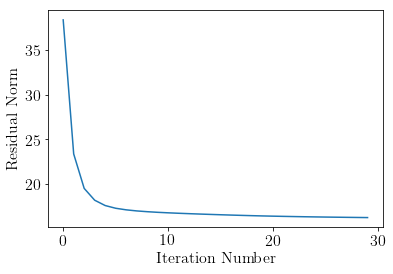

Original matrix:
[[0.30991736 0.3677686  0.41735536 ... 0.15289256 0.16115703 0.1570248 ]
 [0.45454547 0.47107437 0.5123967  ... 0.15289256 0.15289256 0.15289256]
 [0.3181818  0.40082645 0.49173555 ... 0.14049587 0.14876033 0.15289256]
 ...
 [0.6694215  0.6818182  0.7066116  ... 0.11157025 0.11157025 0.10743801]
 [0.6280992  0.60330576 0.6280992  ... 0.15289256 0.11157025 0.10743801]
 [0.5165289  0.46280992 0.28099173 ... 0.35950413 0.3553719  0.38429752]]
Left factor Y:
[[ 1.61173843e-01 -4.98156262e-08  9.78858445e-01 -3.94174634e-08
   9.94939126e-01  8.02921501e-02  9.41592183e-01]
 [ 1.55837358e+00  1.96305612e-07  4.08621150e-01  1.72827705e+00
   6.72030149e-01  1.60241365e-02 -7.09453114e-08]
 [ 6.69624962e-02  1.33620422e-01  1.03425100e+00 -2.20560541e-07
   1.23989556e+00  1.06459789e-07  6.83073842e-01]
 [-2.27326705e-07  2.93567763e+00 -1.61843856e-07  2.55312052e-01
   3.84518846e-07  3.25715280e-01  1.63971476e+00]
 [ 9.21851309e-01  7.17107261e-01  5.18422616e-01  1.642

In [7]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Set plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

# Create the plot.
plt.plot(residual)
plt.xlabel('Iteration Number')
plt.ylabel('Residual Norm')
plt.show()

#
# Print results.
#
print('Original matrix:')
print(A)
print('Left factor Y:')
print(Y)
print('Right factor X:')
print(X)
print('Residual A - Y * X:')
print(A - Y.dot(X))
print('Residual after {} iterations: {}'.format(iter_num, prob.value))

In [8]:
X.shape

(7, 4096)

Shape of data = (7, 4096)


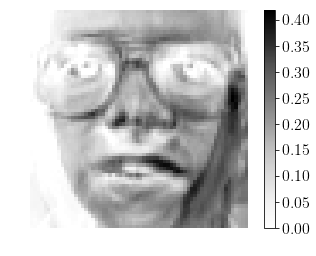

In [10]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[0].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (7, 4096)


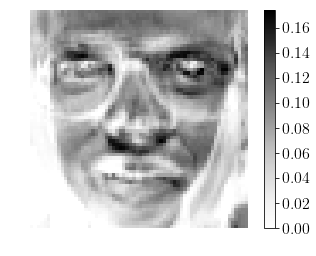

In [11]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[1].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (7, 4096)


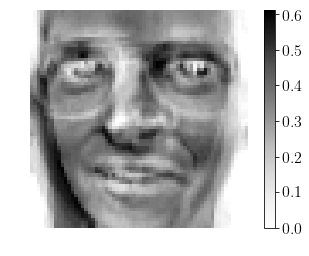

In [12]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[2].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (7, 4096)


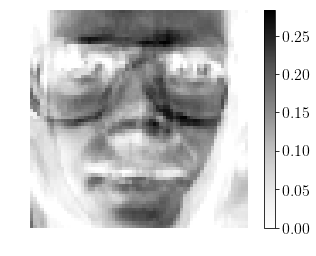

In [17]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[3].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (7, 4096)


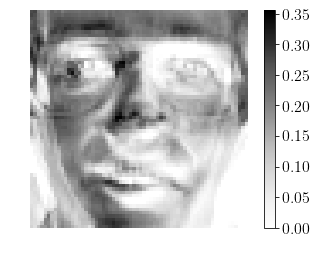

In [13]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[4].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (7, 4096)


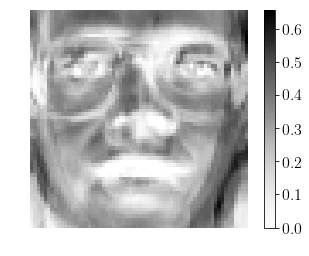

In [14]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[5].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (7, 4096)


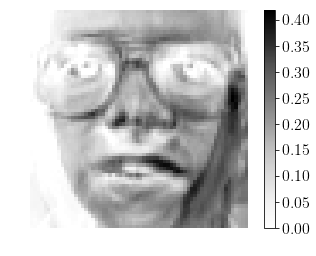

In [15]:
print("Shape of data = {}".format(X.shape))
plt.imshow(X[6].reshape(64,64), cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [18]:
Y.shape

(18, 7)

Shape of data = (18, 7)


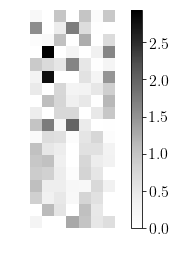

In [19]:
print("Shape of data = {}".format(Y.shape))
plt.imshow(Y, cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")